# Introduction

**Nama      : Titian Fitriana Prasasti**

***Batch    : 001 HCK***

**Dataset   :** `Facebook AI - PersonaChat` dari kaggle.com

### Objectives

- Membuat Chat-Bot dengan model NLP menggunakan algoritma RNN dengan skema Sequence to Sequence.
- Dalam Skema Seq2Seq penulis akan membuat 2 model yaitu model encoder sebagai input berisi pernyataan dari user kemudian model decoder yang akan mengeluarkan output berupa jawaban oleh bot.
- Melakukan evaluasi, improvement, dan analisis terhadap model
- Melakukan deployment sederhana via Streamlit

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder


from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model
from statistics import mean, median

In [47]:
data = pd.read_csv("personality.csv")
data

,Unnamed: 0,Persona,chat
0,0,i like to remodel homes. i like to go hunting...,"hi , how are you doing ? i am getting ready to..."
1,1,my mom is my best friend. i have four sisters...,"hi , how are you doing today ?\ni am spending ..."
2,2,i had a gig at local theater last night. i wo...,"we all live in a yellow submarine , a yellow s..."
3,3,i am very athletic. i wear contacts. i have b...,hi ! i work as a gourmet cook .\ni do not like...
4,4,i am primarily a meat eater. i am a guitar pl...,how are you doing today\nwhat do you do for ca...
...,...,...,...
8934,8934,my favorite food is fried chicken. i have a t...,"good evening , i have been having a terrible t..."
8935,8935,i love fast food. i am a stay at home mom. i ...,hi there how is work\ni do not work these days...
8936,8936,my family and i go camping every month. i am ...,"hello , i have a daughter who is in kindergart..."
8937,8937,i have red hair. i work at a retail store. i ...,hi . how are you doing ?\ni am doing well . ju...


In [48]:
data.head()

,Unnamed: 0,Persona,chat
0,0,i like to remodel homes. i like to go hunting...,"hi , how are you doing ? i am getting ready to..."
1,1,my mom is my best friend. i have four sisters...,"hi , how are you doing today ?\ni am spending ..."
2,2,i had a gig at local theater last night. i wo...,"we all live in a yellow submarine , a yellow s..."
3,3,i am very athletic. i wear contacts. i have b...,hi ! i work as a gourmet cook .\ni do not like...
4,4,i am primarily a meat eater. i am a guitar pl...,how are you doing today\nwhat do you do for ca...


In [49]:
data.tail()

,Unnamed: 0,Persona,chat
8934,8934,my favorite food is fried chicken. i have a t...,"good evening , i have been having a terrible t..."
8935,8935,i love fast food. i am a stay at home mom. i ...,hi there how is work\ni do not work these days...
8936,8936,my family and i go camping every month. i am ...,"hello , i have a daughter who is in kindergart..."
8937,8937,i have red hair. i work at a retail store. i ...,hi . how are you doing ?\ni am doing well . ju...
8938,8938,i m applying for publishing jobs. the only au...,hello ! how are you today ?\nhello i am good ....


# Exploratory Data analysis (EDA)

In [50]:
# Melihat Teks Pertama

print(data.chat[0])

hi , how are you doing ? i am getting ready to do some cheetah chasing to stay in shape .
you must be very fast . hunting is one of my favorite hobbies .
i am ! for my hobby i like to do canning or some whittling .
i also remodel homes when i am not out bow hunting .
that is neat . when i was in high school i placed 6th in 100m dash !
that is awesome . do you have a favorite season or time of year ?
i do not . but i do have a favorite meat since that is all i eat exclusively .
what is your favorite meat to eat ?
i would have to say its prime rib . do you have any favorite foods ?
i like chicken or macaroni and cheese .
do you have anything planned for today ? i think i am going to do some canning .
i am going to watch football . what are you canning ?
i think i will can some jam . do you also play footfall for fun ?
if i have time outside of hunting and remodeling homes . which is not much !



In [51]:
print(data.Persona[0])

 i like to remodel homes. i like to go hunting. i like to shoot a bow. my favorite holiday is halloween.


In [52]:
print(data.chat[2000])

i like acting . i am in a telenovela now .
fun . dancing is my ticket to fame .
what kind of dancing ? were you in a show ? i love musicals .
anything but dancing to country music , yuck , i hate it .
do you watch dancing with the stars ? they make it look easy .
yeah , they do . but i am better than some of them . if i could only spell , sigh .
why do you need to spell ? having problems in school ?
no . just wish i were a better speller , but i am blonde people over look it .
you can learn . there are certain rules for most of it . english is difficult .
yeah . my hair goes all the way down to my knees . how about you ?
what kind of dancing do you like to do the best ? do you perform ?
sometimes i perform ballet , when i am not walking dogs at the shelter .
animals scare me . i got bit during a commercial when i was 9 .
i am so sorry . that had to be traumatic .
they expected me to just carry on . i cried and got yelled at .
wow . that is so sad . take courage , you are not alone .



In [1]:
print(data.Persona[2000])

NameError: name 'data' is not defined

Dari dataset tersebut dapat kita lihat bahwa pola kalimat pada kolom `chat` merupakan uraian terkait informasi-informasi yang bersifat personal dan jumlah kata dalam satu kolom terbilang cukup banyak. Kemudian untuk  jawaban bot dalam hal ini kolom `Persona`, terlihat bahwa kalimat yang disediakan merujuk pada konteks besar bahkan ringkasan konteks dari keseluruhan kalimat yang ada pada setiap kolom `chat`. Dapat diamati juga bahwa setiap baris memiliki tema-tema yang beragam. Dari informasi yang diperoleh via sumber dataset ini di kaggle, jawaban dengan topik personal dianggap dapat menghasilkan obrolan yang lebih ***engaging***. 

# Data Preprocessing

Dataset ini sudah terbilang bersih dan hanya membutuhkan preprocessing yang minimal karena semua huruf sudah dalam bentuk huruf kecil (lower case). Tidak ditemukan tanda baca yang perlu di keluarkan seperti tanda seru, titik dan tanda tanya karena dalam konteks chat-bot hal ini diperlukan untuk menambahkan informasi terkait konteks kalimat. Kemudian tidak diperlukan juga untuk drop stopword maupun stemming karena chat-bot perlu memberikan output yang lengkap, jika kita mengedrop stopwords maka output jawaban bisa terpotong dan kehilangan arti. Sehingga preprocessing yang dilakukan hanya memisahkan titik ('.') pada kolom `Persona` agar dapat kita dapat melakukan proses tokenize.

In [5]:
teks = data.Persona[0]
def text_proses(teks):
  teks = re.sub('([.])', r' \1 ', teks)
  teks = re.sub('\s{2,}', ' ', teks)
  return teks

In [6]:
data['persona_proc'] = data['Persona'].apply(lambda x: text_proses(x))
data

,Unnamed: 0,Persona,chat,persona_proc
0,0,i like to remodel homes. i like to go hunting...,"hi , how are you doing ? i am getting ready to...",i like to remodel homes . i like to go huntin...
1,1,my mom is my best friend. i have four sisters...,"hi , how are you doing today ?\ni am spending ...",my mom is my best friend . i have four sister...
2,2,i had a gig at local theater last night. i wo...,"we all live in a yellow submarine , a yellow s...",i had a gig at local theater last night . i w...
3,3,i am very athletic. i wear contacts. i have b...,hi ! i work as a gourmet cook .\ni do not like...,i am very athletic . i wear contacts . i have...
4,4,i am primarily a meat eater. i am a guitar pl...,how are you doing today\nwhat do you do for ca...,i am primarily a meat eater . i am a guitar p...
...,...,...,...,...
8934,8934,my favorite food is fried chicken. i have a t...,"good evening , i have been having a terrible t...",my favorite food is fried chicken . i have a ...
8935,8935,i love fast food. i am a stay at home mom. i ...,hi there how is work\ni do not work these days...,i love fast food . i am a stay at home mom . ...
8936,8936,my family and i go camping every month. i am ...,"hello , i have a daughter who is in kindergart...",my family and i go camping every month . i am...
8937,8937,i have red hair. i work at a retail store. i ...,hi . how are you doing ?\ni am doing well . ju...,i have red hair . i work at a retail store . ...


### Tokenizer

Selanjutnya kita melakukan proses tokenizer untuk memisahkan setiap kata dalam kolom untuk menjadi individual token. Hal ini dilakukan untuk mempersiapkan data sebelum dilakukan padding dan embedding.

In [7]:
tokenize_encoder = Tokenizer()
tokenize_decoder = Tokenizer()

In [8]:
# Input Encoder
tokenize_encoder.fit_on_texts(data['chat'])
input_encoder = tokenize_encoder.texts_to_sequences(data['chat'])

In [9]:
# Input Decoder
tokenize_decoder.fit_on_texts(data['persona_proc'].apply(lambda x: "<START> "+ x +" <END>"))
input_decoder = tokenize_decoder.texts_to_sequences(data['persona_proc'].apply(lambda x: "<START> "+ x +" <END>"))

In [10]:
# Target 
target = tokenize_decoder.texts_to_sequences(data['persona_proc'].apply(lambda x: x +" <END>"))

In [59]:
pickle.dump(tokenize_encoder, open('tokenize_encoder.pkl', 'wb'))

In [60]:
pickle.dump(tokenize_decoder, open('tokenize_decoder.pkl', 'wb'))

### Padding

Padding dilakukan untuk menyamakan jumlah keseluruhan kata yang sudah ditokenize menjadi sejumlah maksimal token yang ada pada setiap kolom. 

In [11]:
# Persiapan Padding & Embedding input_encoder
jml_vocab_enc = len(tokenize_encoder.word_index)+1
med_enc = median([len(i.split(" ")) for i in data['chat']])

Pada jumlah token pada encoder dikarenakan jumlahnya yang sangat banyak mencapai 448 token sehingga dipilih nilai median dengan harapan dapat mengurangi beban training dan meningkatkan akurasi model.

In [12]:
# Persiapan Padding & Embedding input_decoder
jml_vocab_dec = len(tokenize_decoder.word_index)+1
max_sen_len_dec = max([len(i.split(" ")) for i in data['persona_proc']])

In [13]:
# Persiapan Padding & Embedding target
jml_vocab_target = len(tokenize_decoder.word_index)+1
max_sen_len_target = max([len(i.split(" ")) for i in data['persona_proc']])

In [14]:
# Padding input_encoder

padding_enc = pad_sequences(input_encoder,
                            maxlen=med_enc,
                            padding='post'
                            )

Median dipakai karena jumlah kalimat dalam 1 cell mencapai 448 kata

In [15]:
# Padding input_decoder

padding_dec = pad_sequences(input_decoder,
                            maxlen=max_sen_len_dec,
                            padding='post'
                            )

In [16]:
# Padding input_target

padding_target = pad_sequences(target,
                               maxlen=max_sen_len_target,
                               padding='post'
                               )

### Embedding

Embedding dilakukan untuk mengubah token yang kita miliki menjadi menjadi bentuk vektor agar dapat dibaca oleh model

In [17]:
# Embedding input_encoder

embedding_enc = Embedding(input_dim=jml_vocab_enc,
                          output_dim=128,
                          embeddings_initializer="uniform",
                          input_length=med_enc
                          )

In [18]:
# Embedding input_decoder

embedding_dec = Embedding(input_dim=jml_vocab_dec,
                          output_dim=128,
                          embeddings_initializer="uniform",
                          input_length=max_sen_len_dec
                          )

In [19]:
target_ = tf.keras.utils.to_categorical(padding_target, jml_vocab_target)

### Target Categorical

Mengubah token pada variable target menjadi kategori

# Modelling
### Base Model

In [70]:
# Input Encoder
input_enc_base = tf.keras.layers.Input(shape=(None,))
emb_enc = tf.keras.layers.Embedding(input_dim=jml_vocab_enc,
                          output_dim=128,
                          embeddings_initializer="uniform",
                          input_length=med_enc
                          )(input_enc_base)
lstm_enc, state_h, state_c = LSTM(32, return_state=True)(emb_enc)

context_vector = [state_h, state_c]

# Input Decoder
input_dec_base = tf.keras.layers.Input(shape=(None,))
emb_dec = Embedding(input_dim=jml_vocab_dec,
                          output_dim=128,
                          embeddings_initializer="uniform",
                          input_length=max_sen_len_dec
                          )(input_dec_base)
lstm_dec_base = LSTM(32, return_state=True, return_sequences=True)
lstm_dec1,_,_ = lstm_dec_base(emb_dec, initial_state=context_vector)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_dec1)
output = tf.keras.layers.Dense(jml_vocab_dec, activation='softmax')(dense)


model1 = tf.keras.models.Model(inputs=[input_enc_base,input_dec_base],outputs=output)

model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, None, 128)    2389632     ['input_21[0][0]']               
                                                                                                  
 embedding_21 (Embedding)       (None, None, 128)    483328      ['input_22[0][0]']               
                                                                                           

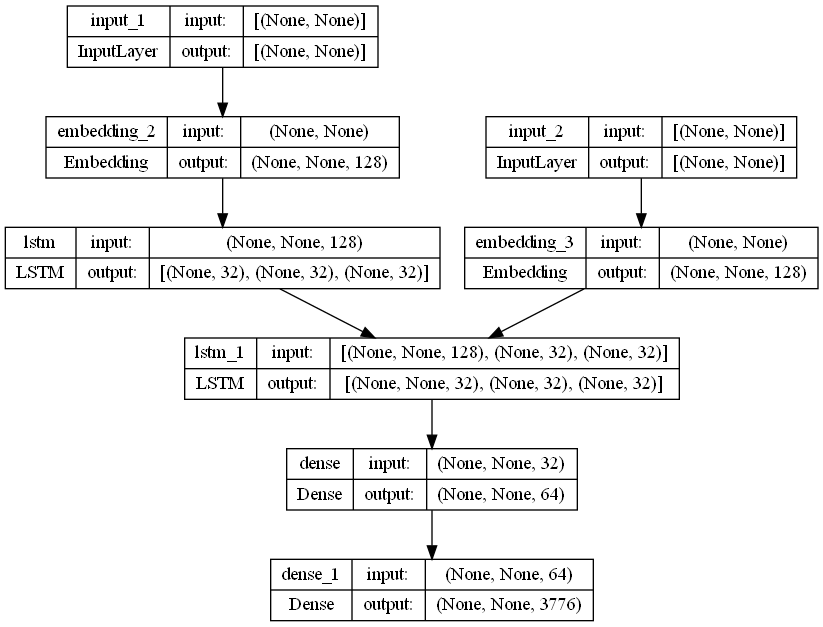

In [55]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [21]:
model1.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [22]:
history1 = model1.fit(x=[padding_enc,padding_dec], y=target_, validation_split=0.2, batch_size=64, epochs=20)

Epoch 1/20
112/112 [==============================] - 71s 561ms/step - loss: 4.2696 - accuracy: 0.6449 - val_loss: 2.1011 - val_accuracy: 0.6527
Epoch 2/20
112/112 [==============================] - 70s 624ms/step - loss: 1.9405 - accuracy: 0.6955 - val_loss: 1.9073 - val_accuracy: 0.6988
Epoch 3/20
112/112 [==============================] - 69s 617ms/step - loss: 1.8584 - accuracy: 0.7022 - val_loss: 1.8428 - val_accuracy: 0.7071
Epoch 4/20
112/112 [==============================] - 66s 588ms/step - loss: 1.7606 - accuracy: 0.7212 - val_loss: 1.7307 - val_accuracy: 0.7234
Epoch 5/20
112/112 [==============================] - 72s 639ms/step - loss: 1.6665 - accuracy: 0.7299 - val_loss: 1.6548 - val_accuracy: 0.7314
Epoch 6/20
112/112 [==============================] - 70s 622ms/step - loss: 1.5758 - accuracy: 0.7432 - val_loss: 1.5553 - val_accuracy: 0.7434
Epoch 7/20
112/112 [==============================] - 66s 589ms/step - loss: 1.4838 - accuracy: 0.7515 - val_loss: 1.4798 - val_ac

Text(0.5, 0, 'Epoch')

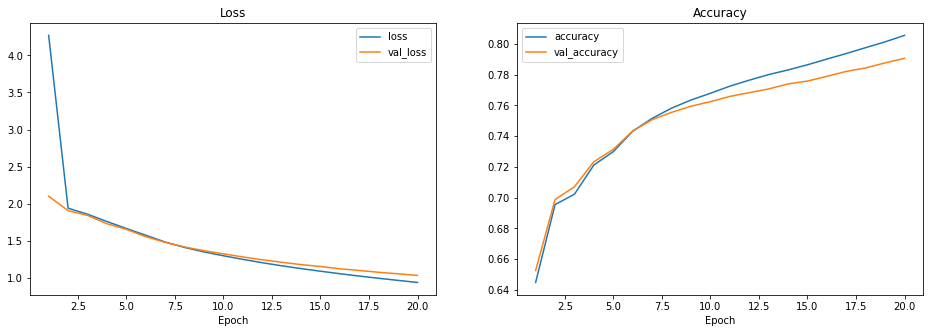

In [23]:
epoch=20

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history1.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history1.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history1.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history1.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

Terlihat grafik dari base model sudah cukup baik tidak nampak adanya exploding maupun vanishing gradient. 
berikut adalah metric evaluasi dari kedua model yang sudah dibuat:

| Base Model        | Loss      | Accuracy  |
|  :---             |  :----:   |    :----: |
| Train             | 0.9390    | 0.8055    |
| Validation        | 1.0334    | 0.7905    |

Terlihat model terbilang fit namun mari kita coba tingkatnya akurasi dan mengurangi loss nya dengan model improvement. L

### Model Improvement

In [65]:
# Input Encoder
input_enc = tf.keras.layers.Input(shape=(None,))
emb_enc = tf.keras.layers.Embedding(input_dim=jml_vocab_enc,
                          output_dim=128,
                          embeddings_initializer="uniform",
                          input_length=med_enc
                          )(input_enc)
lstm_enc, state_h, state_c = LSTM(32, return_state=True)(emb_enc)

context_vector = [state_h, state_c]

# Input Decoder
input_dec = tf.keras.layers.Input(shape=(None,))
emb_dec = Embedding(input_dim=jml_vocab_dec,
                          output_dim=128,
                          embeddings_initializer="uniform",
                          input_length=max_sen_len_dec
                          )(input_dec)
lstm_dec_imp = LSTM(32, return_state= True, return_sequences=True)
lstm_dec1,_,_ = lstm_dec_imp(emb_dec, initial_state=context_vector)

dense_1 = tf.keras.layers.Dense(32, activation='relu')
dense1 = dense_1(lstm_dec1)
layers_1 = tf.keras.layers.BatchNormalization()
layers1 = layers_1(dense1)
dense_2 = tf.keras.layers.Dense(16, activation='relu')
dense1 = dense_2(layers1)
layers_2 = tf.keras.layers.BatchNormalization()
layers1 = layers_2(dense1)
dense_3 = tf.keras.layers.Dense(8, activation='relu')
dense1 = dense_3(layers1)
output_gru = tf.keras.layers.Dense(jml_vocab_dec, activation='softmax')
output1 = output_gru(dense1)


model_imp2 = tf.keras.models.Model(inputs=[input_enc,input_dec],outputs=output1)

model_imp2.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, None, 128)    2389632     ['input_17[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, None, 128)    483328      ['input_18[0][0]']               
                                                                                            

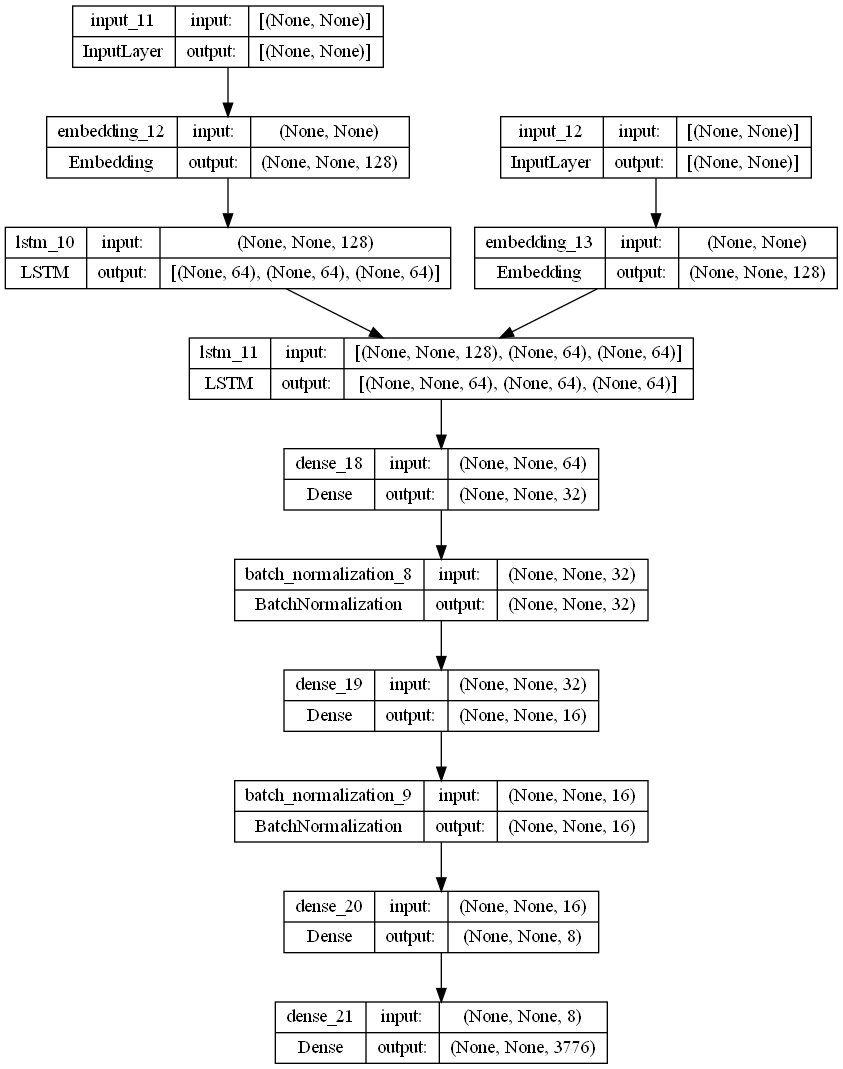

In [40]:
plot_model(model_imp2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)   # plot model

In [44]:
model_imp2.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')

In [45]:
history2 = model_imp2.fit(x=[padding_enc,padding_dec], y=target_, validation_split=0.2, batch_size=32, epochs=20)

Epoch 1/20
224/224 [==============================] - 88s 336ms/step - loss: 4.6211 - accuracy: 0.6150 - val_loss: 4.4581 - val_accuracy: 0.6607
Epoch 2/20
224/224 [==============================] - 84s 375ms/step - loss: 2.0109 - accuracy: 0.6552 - val_loss: 2.2391 - val_accuracy: 0.6528
Epoch 3/20
224/224 [==============================] - 87s 390ms/step - loss: 1.9130 - accuracy: 0.6556 - val_loss: 1.9238 - val_accuracy: 0.6527
Epoch 4/20
224/224 [==============================] - 84s 375ms/step - loss: 1.8797 - accuracy: 0.6556 - val_loss: 1.8954 - val_accuracy: 0.6528
Epoch 5/20
224/224 [==============================] - 71s 318ms/step - loss: 1.8510 - accuracy: 0.6561 - val_loss: 1.8917 - val_accuracy: 0.6531
Epoch 6/20
224/224 [==============================] - 74s 329ms/step - loss: 1.8225 - accuracy: 0.6578 - val_loss: 1.8483 - val_accuracy: 0.6574
Epoch 7/20
224/224 [==============================] - 86s 384ms/step - loss: 1.7943 - accuracy: 0.6605 - val_loss: 1.8229 - val_ac

Text(0.5, 0, 'Epoch')

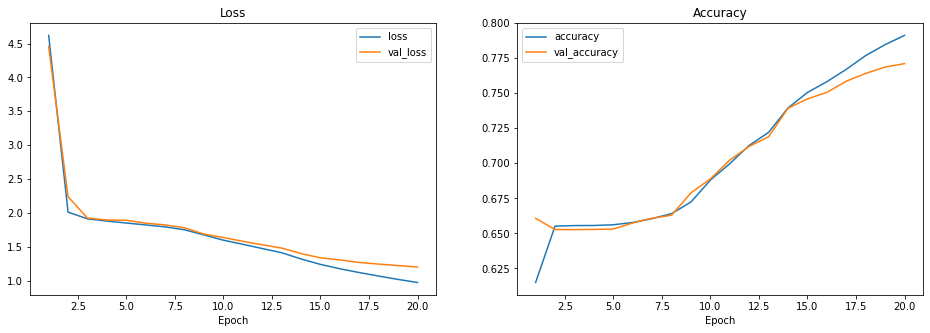

In [46]:
epoch=20

fig, ax = plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,epoch+1),history2.history['loss'],label='loss')
ax[0].plot(range(1,epoch+1),history2.history['val_loss'],label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[0].set_xlabel('Epoch')

ax[1].plot(range(1,epoch+1),history2.history['accuracy'],label='accuracy')
ax[1].plot(range(1,epoch+1),history2.history['val_accuracy'],label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')

Jika dibandingkan dengan base model ternyata model yang di improve bisa dibilang memiliki performa yang kurang:

| Base Model        | Loss      | Accuracy  |
|  :---             |  :----:   |    :----: |
| Train             | 0.9390    | 0.8055    |
| Validation        | 1.0334    | 0.7905    |
-
| Improved Model    | Loss      | Accuracy  |
|  :---             |  :----:   |    :----: |
| Train             | 0.9736    | 0.7912    |
| Validation        | 1.2017    | 0.7710    |

Dengan begitu maka penulis memilih base model sebagai model yang akan dipakai lebih lanjut

In [56]:
model1.save('model_base.h5')

# Model Inference

In [71]:
# model encoder
model_encoder = Model(input_enc_base,context_vector)
model_encoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_20 (Embedding)    (None, None, 128)         2389632   
                                                                 
 lstm_18 (LSTM)              [(None, 32),              20608     
                              (None, 32),                        
                              (None, 32)]                        
                                                                 
Total params: 2,410,240
Trainable params: 2,410,240
Non-trainable params: 0
_________________________________________________________________


In [80]:
model_encoder.save('model_encoder_new.h5')

In [72]:

# model decoder

inp_decoder_state_h = tf.keras.layers.Input(shape=( 32 ,))
inp_decoder_state_c = tf.keras.layers.Input(shape=( 32 ,))

inp_decoder_states = [inp_decoder_state_h, inp_decoder_state_c]

decoder_outputs, state_h, state_c = lstm_dec_base(emb_dec, inp_decoder_states)
decoder_states = [state_h, state_c]

layer_dec = dense_1(decoder_outputs)
layer_dec = layers_1(layer_dec)
layer_dec = dense_2(layer_dec)
layer_dec = layers_2(layer_dec)
layer_dec = dense_3(layer_dec)
output_inf = output_gru(layer_dec)

model_decoder = tf.keras.models.Model(inputs = [input_dec_base] + inp_decoder_states, outputs = [output_inf] + decoder_states)

model_decoder.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_21 (Embedding)       (None, None, 128)    483328      ['input_22[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 32)]         0           []                               
                                                                                           

In [81]:
model_decoder.save('model_decoder_new.h5')

In [74]:
model_encoder.trainable = True
model_decoder.trainable = True

In [75]:
jawaban = dict((v,k) for k,v in tokenize_decoder.word_index.items())

In [87]:
pickle.dump(jawaban, open('jawaban_tokenize_decoder.pkl', 'wb'))

In [76]:
inf = tokenize_encoder.texts_to_sequences(["i like going to the lake"])
inf = pad_sequences( inf, maxlen=med_enc, padding='post' )

state_inf = model_encoder.predict(inf,verbose=0)

word = ''
sentences = []
target_seq = np.array([[tokenize_decoder.word_index['start']]])
while True:
  dec_out, h, c = model_decoder.predict([target_seq] + state_inf, verbose=0)

  wd_id = np.argmax(dec_out[0][0])
  word = jawaban[wd_id]
  sentences.append(word)

  target_seq = np.array([[wd_id]])
  state_inf = [h,c]

  if word == 'end' or len(sentences)>=50:
    break
if sentences[-1] == 'end':
  print(' '.join(sentences[:-1]))

else:
  print(' '.join(sentences))

waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress waitress


In [77]:
tokenize_decoder.word_index['start']

4

# Conclusion

Sayangnya dapat kita lihat model belum dapat memberikan output yang kita inginkan. Hal ini bisa terjadi karena memang nilai akurasi yang masih terbilang rendah dan loss yang terbilang tinggi. Terkait kekurangan dari skema model sequence to sequence dari beberapa paper menyatakan bahwa kekurangan yang paling besar adalah skema model ini sangat rentan terhadap variable sequence yang panjang. Dari paper-paper tersebut juga dapat diamati bahwa data training biasanya berupa input-input sederhana. Sedangkan jika kita lihat pada dataset ini panjang token dalam 1 baris bisa mencapai 448 buah. Dari paper tersebut juga dapat kita simpulkan skema model seq2seq sangat prone to information lost. Jika sequencenya panjang maka loss juga bisa semakin besar. Bahkan dalam paper tersebut lossnya lebih besar daripada model yang penulis buat ini. Dengan segala keterbatasan, diharapkan di masa depan dapat menemukan improvement yang paling optimal. 

Dalam pengerjaannya model sudah di improve berulang kali dengan hasil inference yang tidak konsisten sehingga perlu dilakukan tinjauan lebih lanjut. 


sumber paper:
https://arxiv.org/ftp/arxiv/papers/2006/2006.02767.pdf
https://www.researchgate.net/profile/Prassanna-Jayachandran/publication/341643048_Towards_Building_A_Neural_Conversation_Chatbot_Through_Seq2Seq_Model/links/5eccf6eea6fdcc90d699b89e/Towards-Building-A-Neural-Conversation-Chatbot-Through-Seq2Seq-Model.pdf